## Transformer Fault detection Using Scalogram images 

In [1]:
# Importing essential libraries for the project

# Numerical operations
import numpy as np 

# TensorFlow and Keras for building neural networks
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization, LSTM

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# File handling
import pickle
import os
from glob import glob
import joblib

# Data manipulation
import pandas as pd

# Machine learning algorithms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Optimizers and callbacks for model training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Preprocessing images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

# Pre-trained models
from keras.applications import VGG16

# Set up Matplotlib for better image display
from matplotlib import rcParams


In [4]:
# Loading image dataset and setting target image size

# Load the images from a compressed .npz file
images = np.load(r"C:\Users\David Modupe\Desktop\Final Year Project\Dataset\fault_tester.npz", allow_pickle=True)

# Extract the image data from the dataset
image_data = images['data']

# Set target image size for resizing images in the model
target_size = (128, 128)


In [5]:
# Display the keys and the shape of the dataset to understand its structure

# Check for keys in the loaded dataset (e.g., 'data', 'labels')
images.keys()

# Iterate through the keys in the dataset and print their corresponding shapes
for key in images.keys():
    image = images[key]
    print(f"Key: {key}, Shape: {image.shape}")


Key: data, Shape: (1210,)


In [6]:
# Extract the image data for further processing
image = images['data']


In [7]:
s: print(images['data'][:5])

[{'image': array([[[ 49,  23,  70],
         [ 49,  23,  70],
         [ 49,  23,  70],
         ...,
         [ 62,  57, 147],
         [ 62,  57, 147],
         [ 62,  57, 147]],

        [[ 49,  23,  70],
         [ 49,  23,  70],
         [ 49,  23,  70],
         ...,
         [ 62,  57, 147],
         [ 62,  57, 147],
         [ 62,  57, 147]],

        [[ 49,  23,  70],
         [ 49,  23,  70],
         [ 49,  23,  70],
         ...,
         [ 63,  58, 148],
         [ 63,  58, 148],
         [ 63,  58, 148]],

        ...,

        [[ 49,  18,  59],
         [ 49,  18,  59],
         [ 49,  18,  59],
         ...,
         [ 49,  18,  59],
         [ 49,  18,  59],
         [ 49,  18,  59]],

        [[ 49,  18,  59],
         [ 49,  18,  59],
         [ 49,  18,  59],
         ...,
         [ 49,  18,  59],
         [ 49,  18,  59],
         [ 49,  18,  59]],

        [[ 49,  18,  59],
         [ 49,  18,  59],
         [ 49,  18,  59],
         ...,
         [ 49,  18,  59]

In [8]:
X = []
health_labels = []
side_labels = []
phase_labels = []
percent_labels = []


In [9]:
# Process each item in the image_data
for item in image_data:
    # Check if the necessary keys are in the item
    if 'image' in item and 'healthLabel' in item and 'sideLabel' in item and 'phaseLabel' in item and 'percentLabel' in item:
        img = item['image']
        # Resize the image if it doesn't match the target size
        if img.shape[:2] != target_size:
            img = cv2.resize(img, target_size)
        X.append(img)
        health_labels.append(item['healthLabel'])
        side_labels.append(item['sideLabel'])
        phase_labels.append(item['phaseLabel'])
        percent_labels.append(item['percentLabel'])
    else:
        print(f"Missing keys in item: {item.keys()}")

In [11]:
# Convert lists to numpy arrays and normalize images
X = np.array(X) / 255.0
health_labels = np.array(health_labels)
side_labels = np.array(side_labels)
phase_labels = np.array(phase_labels)
percent_labels = np.array(percent_labels)

In [12]:
# Inspect the structure of image_data
for i, item in enumerate(image_data[:5]):
    print(f"Item {i}:")
    for key, value in item.items():
        print(f"  {key}: {type(value)}")
        if isinstance(value, np.ndarray):
            print(f"    Shape: {value.shape}")

Item 0:
  image: <class 'numpy.ndarray'>
    Shape: (256, 1536, 3)
  healthLabel: <class 'str'>
  sideLabel: <class 'str'>
  phaseLabel: <class 'str'>
  percentLabel: <class 'float'>
Item 1:
  image: <class 'numpy.ndarray'>
    Shape: (256, 256, 3)
  healthLabel: <class 'str'>
  sideLabel: <class 'str'>
  phaseLabel: <class 'str'>
  percentLabel: <class 'str'>
Item 2:
  image: <class 'numpy.ndarray'>
    Shape: (256, 256, 3)
  healthLabel: <class 'str'>
  sideLabel: <class 'str'>
  phaseLabel: <class 'str'>
  percentLabel: <class 'str'>
Item 3:
  image: <class 'numpy.ndarray'>
    Shape: (256, 256, 3)
  healthLabel: <class 'str'>
  sideLabel: <class 'str'>
  phaseLabel: <class 'str'>
  percentLabel: <class 'str'>
Item 4:
  image: <class 'numpy.ndarray'>
    Shape: (256, 256, 3)
  healthLabel: <class 'str'>
  sideLabel: <class 'str'>
  phaseLabel: <class 'str'>
  percentLabel: <class 'str'>


In [13]:

# Initialize and fit LabelEncoders for each label type
health_label_encoder = LabelEncoder().fit(health_labels)
side_label_encoder = LabelEncoder().fit(side_labels)
phase_label_encoder = LabelEncoder().fit(phase_labels)
percent_label_encoder = LabelEncoder().fit(percent_labels)



In [14]:
 #Convert labels to categorical
health_labels = tf.keras.utils.to_categorical(health_label_encoder.transform(health_labels))
side_labels = tf.keras.utils.to_categorical(side_label_encoder.transform(side_labels))
phase_labels = tf.keras.utils.to_categorical(phase_label_encoder.transform(phase_labels))
percent_labels = tf.keras.utils.to_categorical(percent_label_encoder.transform(percent_labels))

# Use health_labels for the demonstration. Repeat for other labels if necessary.
labels = health_labels


In [15]:

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, health_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# Print shapes to verify
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (774, 128, 128, 3)
X_test shape: (242, 128, 128, 3)
y_train shape: (774, 2)
y_test shape: (242, 2)


In [16]:

# Assuming y is one-hot encoded
num_classes = y_train.shape[1]

In [17]:
num_classes

2

In [18]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



In [19]:
datagen.fit(X_train)

In [20]:

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

In [22]:
# Model architecture using VGG16
input_tensor = Input(shape=(128, 128, 3))
base_model = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_tensor = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=6,  # Reduced initial number of epochs
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stop]
)

NameError: name 'VGG19' is not defined

In [21]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 1.0000 - loss: 1.2152e-04
Test accuracy: 1.0


In [22]:
# Predict the labels
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step


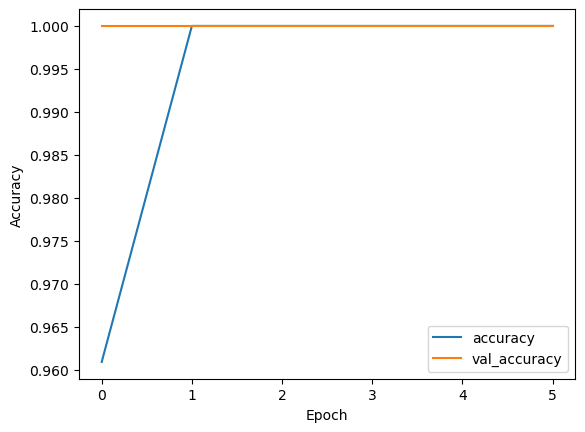

In [23]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        80

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



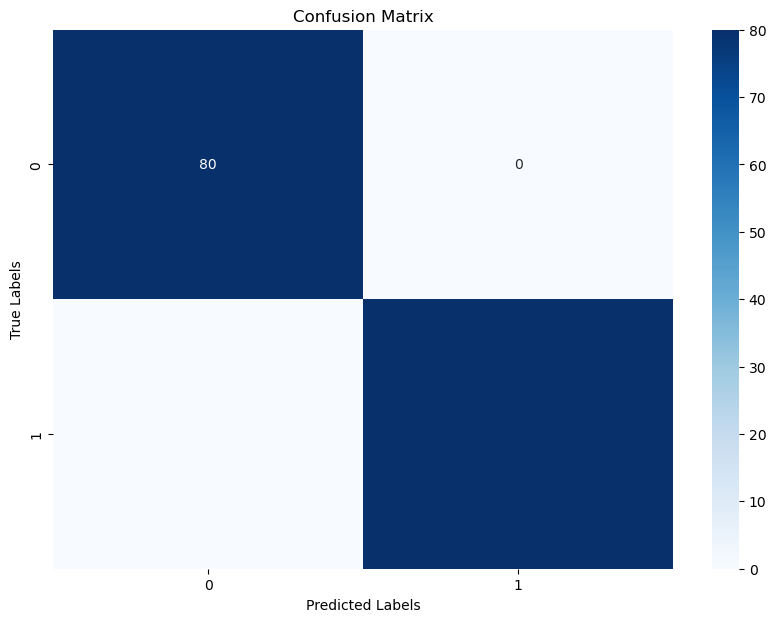

In [24]:

# Evaluate model
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, predicted_labels))

# Confusion matrix
cm = confusion_matrix(y_true, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

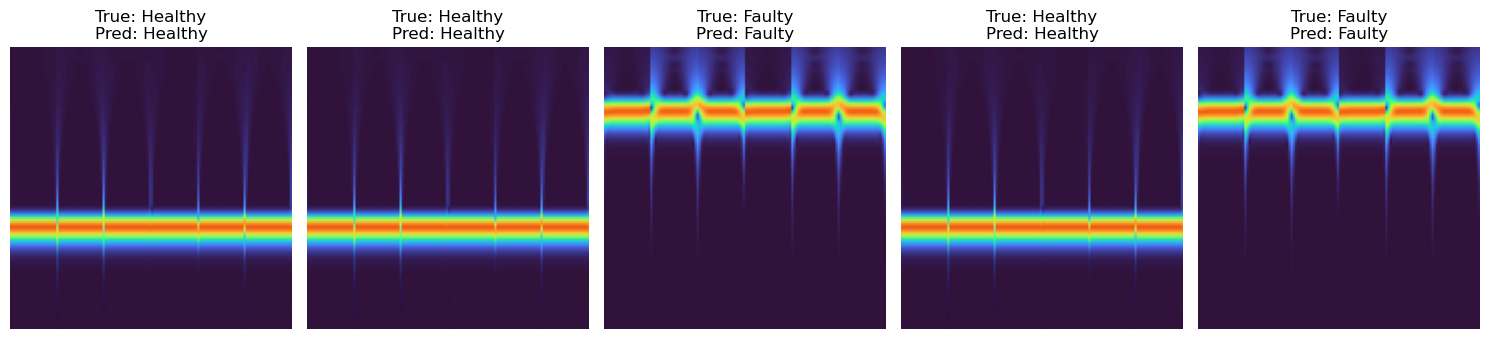

In [25]:


# Example label mappings
label_mapping = {0: 'Faulty', 1: 'Healthy'}  # Replace with actual class names
y_true_labels = [label_mapping[label] for label in y_true]
predicted_labels_str = [label_mapping[label] for label in predicted_labels]

# Plot images with predicted and true labels
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i])
    ax.set_title(f'True: {y_true_labels[i]}\nPred: {predicted_labels_str[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [26]:
# Example label mappings
label_mapping = {0: 'Faulty', 1: 'Healthy'}  # Replace with actual class names

# Save label mappings to a file using Pickle
with open("label_mapping.pkl", "wb") as f:
    pickle.dump(label_mapping, f)

In [27]:
import keras

In [27]:
import keras

In [28]:
keras.saving.save_model(model, 'predictor.keras')
